# Indiana Pines

1. Import dependencies

In [1]:
import random
import torch
import multiprocessing
import numpy as np

import torch.utils.data as data

from lightning import Trainer
from torch import nn
from torch import optim

from src.util.image import (
    scale_image,
    reduce_depth_with_autoencoder,
    reduce_depth_with_patched_autoencoder,
    reduce_depth_with_pca,
)
from src.util.patches import extract_patches
from src.util.torch_device import resolve_torch_device
from src.data.indian_pines import load_indian_pines
from src.model.hsic import HyperSpectralImageClassifier
from src.model.fully_convolutional_lenet import FullyConvolutionalLeNet
from src.visualization.plot import plot_segmentation_comparison
from src.data.dataset_decorator import UnlabeledDatasetDecorator
from src.model.autoencoder import SpatialAutoEncoder, SymmetricPointWiseAutoEncoder
from src.trainer.autoencoder_trainer import AutoEncoderTrainer
from src.data.indian_pines import mask_patched_indian_pines
from src.loss.patch_loss import PatchLoss
from src.trainer.co_trainer import BiCoTrainer
from src.model.ensemble import Ensemble

2. Prepare env

In [2]:
random_seed = 42

random.seed(random_seed)
torch.manual_seed(random_seed)
np.random.seed(random_seed)

batch_size = 56
patch_size = 9
num_epochs = 12
learning_rate = 1e-3
fraction_of_examples = 0.1

device = resolve_torch_device()

generator = torch.Generator()
generator.manual_seed(random_seed)

In [3]:
f"Device is {device}"

'Device is mps'

3. Load dataset

In [4]:
image, labels = load_indian_pines()

image_h, image_w, image_c = image.shape

_, x = scale_image(image)

In [5]:
num_classes = len(np.unique(labels))

f"Number of classes {num_classes}"

'Number of classes 17'

4. Reduce dimensions

In [6]:
reduced_dim_size = 200

In [7]:
# _, x = reduce_depth_with_pca(x, n_components=reduced_dim_size)

In [8]:
# auto_encoder_epochs = 100

# autoencoder = SymmetricPointWiseAutoEncoder([image_c, reduced_dim_size]).to(device)

# criterion = nn.MSELoss().to(device)
# optimizer = optim.Adam(autoencoder.parameters(), lr=1e-3)
# trainer = AutoEncoderTrainer(
#     criterion,
#     auto_encoder_epochs,
#     optimizer,
# )

# x = reduce_depth_with_autoencoder(x, autoencoder, trainer, device)

In [9]:
# auto_encoder_epochs = 100

# autoencoder = SpatialAutoEncoder(
#     input_channels=image_c, embedding_size=reduced_dim_size
# ).to(device)

# trainer = AutoEncoderTrainer(
#     nn.MSELoss(),
#     auto_encoder_epochs,
#     optim.Adam(autoencoder.parameters(), lr=1e-3),
# )

# x = reduce_depth_with_patched_autoencoder(x, patch_size, autoencoder, [trainer], device)

5. Prepare dataset

In [10]:
x, y = extract_patches(x, labels, patch_size=patch_size)

full_ds, labeled_ds, unlabeled_ds = mask_patched_indian_pines(x, y, fraction_of_examples)

In [11]:
cpu_count = multiprocessing.cpu_count()

f"Setting num_workers to {cpu_count}"

'Setting num_workers to 14'

In [12]:
train_loader = data.DataLoader(
    labeled_ds,
    batch_size=batch_size,
    shuffle=True,
    num_workers=cpu_count,
    persistent_workers=True,
    generator=generator,
)
test_loader = data.DataLoader(
    full_ds,
    batch_size=batch_size,
    shuffle=False,
    num_workers=cpu_count,
    persistent_workers=True,
    generator=generator,
)
predict_loader = data.DataLoader(
    UnlabeledDatasetDecorator(full_ds),
    batch_size=batch_size,
    shuffle=False,
    num_workers=cpu_count,
    persistent_workers=True,
    generator=generator,
)

In [13]:
f"Training samples: {len(labeled_ds)}, Testing samples: {len(full_ds)}"

'Training samples: 987, Testing samples: 21025'

4. Train model

In [14]:
model = HyperSpectralImageClassifier(
    FullyConvolutionalLeNet(reduced_dim_size, num_classes),
    num_classes,
    lr=learning_rate,
)

trainer = Trainer(accelerator="auto", max_epochs=num_epochs)

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/alexandermelashchenko/Workspace/spatial-regulated-self-training/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default


In [15]:
trainer.fit(model, train_loader)

/Users/alexandermelashchenko/Workspace/spatial-regulated-self-training/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name             | Type                    | Params | Mode 
---------------------------------------------------------------------
0 | net              | FullyConvolutionalLeNet | 509 K  | train
1 | f1               | MulticlassF1Score       | 0      | train
2 | overall_accuracy | MulticlassAccuracy      | 0      | train
3 | average_accuracy | MulticlassAccuracy      | 0      | train
4 | kappa            | MulticlassCohenKappa    | 0      | train
---------------------------------------------------------------------
509 K     Trainable params
0         Non-trainable params
509 K     Total params
2.040     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode
/Users/alexandermelashchenko/Workspace

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=12` reached.


5. Display prediction

In [16]:
trainer.validate(model, test_loader)

Validation: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
  val_average_accuracy      0.6161712408065796
         val_f1                     nan
        val_kappa           0.4067746698856354
        val_loss             2.532576322555542
  val_overall_accuracy              nan
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'val_loss': 2.532576322555542,
  'val_f1': nan,
  'val_overall_accuracy': nan,
  'val_average_accuracy': 0.6161712408065796,
  'val_kappa': 0.4067746698856354}]

In [17]:
y_pred = trainer.predict(model, predict_loader)

Predicting: |          | 0/? [00:00<?, ?it/s]

In [18]:
y_pred = torch.cat(y_pred, dim=0)

In [19]:
y_pred = torch.argmax(y_pred, dim=1)
y_pred = y_pred.reshape(image_h, image_w)

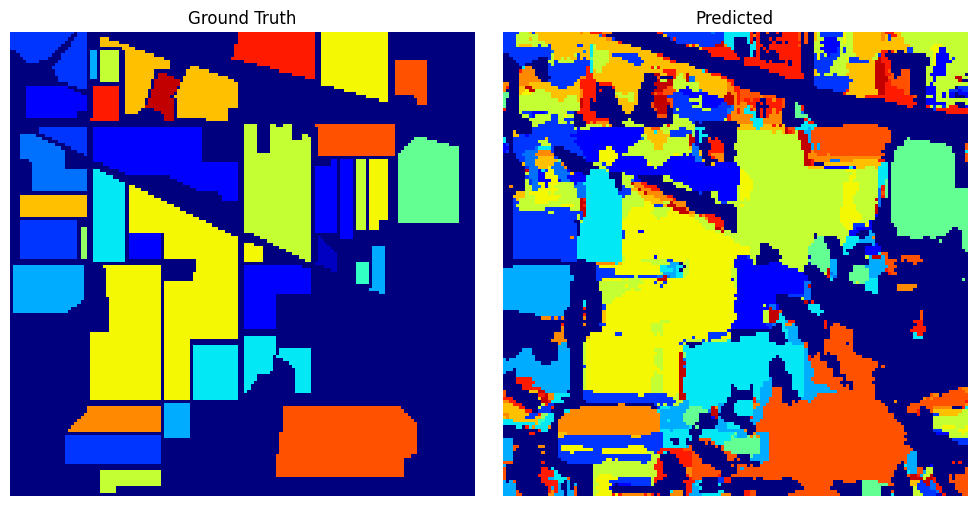

In [20]:
plot_segmentation_comparison(labels, y_pred.numpy())

6. Train semi-supervised model

In [21]:
x_tensor = torch.tensor(x, dtype=torch.float32, device=device).permute(0, 3, 1, 2)

In [22]:
model_1 = FullyConvolutionalLeNet(reduced_dim_size, num_classes).to(device)

model_2 = FullyConvolutionalLeNet(reduced_dim_size, num_classes).to(device)

co_trainer = BiCoTrainer(
    batch_size=batch_size,
    confidence_threshold=0.9,
    generator=generator,
    cpu_count=cpu_count,
    trainer=Trainer(
        accelerator="auto",
        max_epochs=num_epochs,
        enable_model_summary=False,
        enable_checkpointing=False,
    ),
)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [23]:
feedback = co_trainer.fit(
    models=(model_1, model_2),
    model_wrappers=(
        lambda it: HyperSpectralImageClassifier(
            it,
            num_classes,
            learning_rate,
        ),
        lambda it: HyperSpectralImageClassifier(
            it,
            num_classes,
            learning_rate,
        ),
    ),
    labeled=labeled_ds,
    unlabeled=unlabeled_ds,
    eval_dl=test_loader,
)

0it [00:00, ?it/s]

/Users/alexandermelashchenko/Workspace/spatial-regulated-self-training/.venv/lib/python3.12/site-packages/lightning/pytorch/loops/fit_loop.py:310: The number of training batches (9) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=12` reached.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=24` reached.


Validation: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
  val_average_accuracy      0.44351962208747864
         val_f1              0.481990784406662
        val_kappa           0.2646613121032715
        val_loss             2.471290111541748
  val_overall_accuracy              inf
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


/Users/alexandermelashchenko/Workspace/spatial-regulated-self-training/.venv/lib/python3.12/site-packages/lightning/pytorch/loops/fit_loop.py:310: The number of training batches (10) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=36` reached.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=48` reached.


Validation: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
  val_average_accuracy      0.49445897340774536
         val_f1                     nan
        val_kappa           0.3033340871334076
        val_loss             2.385712146759033
  val_overall_accuracy              inf
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=60` reached.
/Users/alexandermelashchenko/Workspace/spatial-regulated-self-training/.venv/lib/python3.12/site-packages/lightning/pytorch/loops/fit_loop.py:310: The number of training batches (11) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=72` reached.


Validation: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
  val_average_accuracy      0.5204756259918213
         val_f1                     nan
        val_kappa           0.32942840456962585
        val_loss            2.3245527744293213
  val_overall_accuracy              nan
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


/Users/alexandermelashchenko/Workspace/spatial-regulated-self-training/.venv/lib/python3.12/site-packages/lightning/pytorch/loops/fit_loop.py:310: The number of training batches (14) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=84` reached.
/Users/alexandermelashchenko/Workspace/spatial-regulated-self-training/.venv/lib/python3.12/site-packages/lightning/pytorch/loops/fit_loop.py:310: The number of training batches (15) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=96` reached.


Validation: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
  val_average_accuracy       0.535790741443634
         val_f1             0.5742171406745911
        val_kappa           0.32299625873565674
        val_loss             2.307137966156006
  val_overall_accuracy              inf
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


/Users/alexandermelashchenko/Workspace/spatial-regulated-self-training/.venv/lib/python3.12/site-packages/lightning/pytorch/loops/fit_loop.py:310: The number of training batches (17) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=108` reached.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=120` reached.


Validation: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
  val_average_accuracy      0.5359334349632263
         val_f1             0.5741263031959534
        val_kappa           0.30830100178718567
        val_loss             2.285374879837036
  val_overall_accuracy              inf
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


/Users/alexandermelashchenko/Workspace/spatial-regulated-self-training/.venv/lib/python3.12/site-packages/lightning/pytorch/loops/fit_loop.py:310: The number of training batches (24) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=132` reached.
/Users/alexandermelashchenko/Workspace/spatial-regulated-self-training/.venv/lib/python3.12/site-packages/lightning/pytorch/loops/fit_loop.py:310: The number of training batches (30) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=144` reached.


Validation: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
  val_average_accuracy      0.5558145046234131
         val_f1             0.5751695036888123
        val_kappa                   nan
        val_loss             2.261105537414551
  val_overall_accuracy              nan
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=156` reached.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=168` reached.


Validation: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
  val_average_accuracy      0.6329131722450256
         val_f1             0.5869994759559631
        val_kappa                   nan
        val_loss             2.010957956314087
  val_overall_accuracy              nan
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=180` reached.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=192` reached.


Validation: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
  val_average_accuracy       0.515814483165741
         val_f1             0.39454853534698486
        val_kappa                   nan
        val_loss             2.119058847427368
  val_overall_accuracy              nan
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=204` reached.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=216` reached.


Validation: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
  val_average_accuracy      0.5136741995811462
         val_f1             0.39121106266975403
        val_kappa                   nan
        val_loss            2.1258797645568848
  val_overall_accuracy    -2.4732807630600274e+18
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=228` reached.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=240` reached.


Validation: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
  val_average_accuracy       0.515814483165741
         val_f1             0.39697685837745667
        val_kappa                   nan
        val_loss            2.1111087799072266
  val_overall_accuracy              inf
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


In [24]:
feedback.history[-1].eval

[{'val_loss': 2.1111087799072266,
  'val_f1': 0.39697685837745667,
  'val_overall_accuracy': inf,
  'val_average_accuracy': 0.515814483165741,
  'val_kappa': nan}]

In [27]:
from src.visualization.plot import plot_epoch_generic


plot_epoch_generic([it.eval["average_accuracy"] for it in feedback.history], desc="Eval f1")

TypeError: list indices must be integers or slices, not str

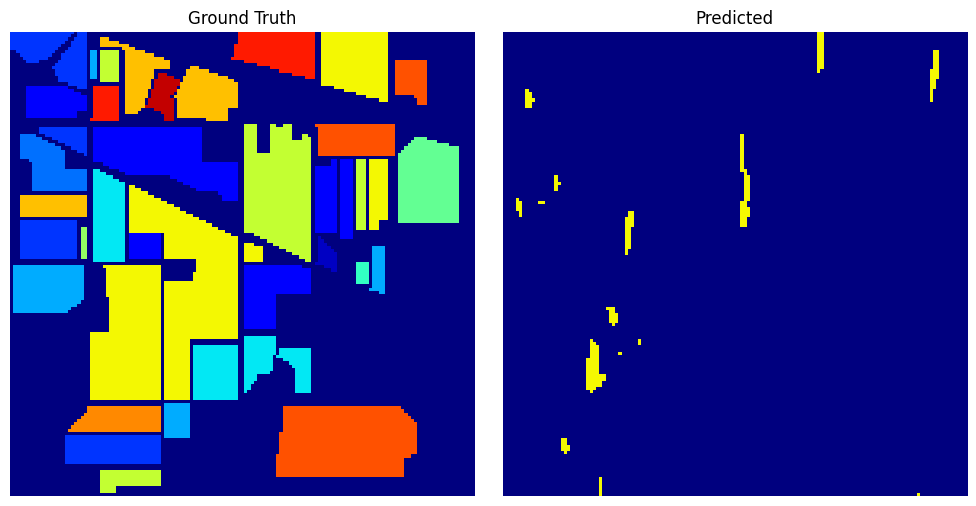

In [29]:
co_trained = Ensemble([model_1, model_2]).to(device)

y_pred = co_trained(x_tensor)
y_pred = torch.argmax(y_pred, dim=1)
y_pred = y_pred.reshape(image_h, image_w)

plot_segmentation_comparison(labels, y_pred.cpu().numpy())